# Danish Corporate Data, Star Wars and the US Economy
### Data-Project - by fbm569 and pbn351
This is the beginning to the data project. It takes you through the journey of linking Danish Corporate Data, the World Economy and pure Star Wars facts.

This project uses data from Erhvervsstyrrelsen's "System-til-system adgang til regnskabsdata", 
which is a JSON + ElasticSearch webservice that contains accounting data for all danish firms. 

The part of the dataset is available on this link: http://web.math.ku.dk/~richard/BSc/DefaultDKTotal.csv 

We will use the datadump above instead of the live data link, due to time limitations. '
In a professional environment and in real life use cases it would be preferable to parse the JSON response into some file.

Furthermore data of the World Economy is taken from the World Bank CPI and finally our Star Wars Data is a grand collection of Lego Star Wars sets over the years containing a vast amount of detailed information. 
The dataset is available here: "https://gist.githubusercontent.com/jncraton/68beb88e6027d9321373/raw/381dcf8c0d4534d420d2488b9c60b1204c9f4363/starwars.csv"


First you will need to hang on a bit while we present and analyze the Danish Corporate Data (zzz...). But do not hesitate we will soon turn to a galaxy far far away (maybe the US economy will be a bump on the ride). 

First we will download the file and import packages for reading the file

In [1]:
#Import packages to read the file
import urllib
import os 


#File location is by default the online location of the dataset, while filename would have to be changed to a local directory to run the code
filelocation = "http://web.math.ku.dk/~richard/BSc/DefaultDKTotal.csv" #File is about 500mb, be sure to have stable connection before you run
filename = "DefaultDKTotal.csv" #What the local filepath annd filename will be, make sure it's a valid path on your pc


#Following is to prevent download of file if file is already downloaded correctly 
#(which we suspect might put down the server when our analysis goes public)
try:
    if os.stat(filename).st_size < 500000000:
        raise    
except:
    testfile = urllib.request.URLopener()
    testfile.retrieve(filelocation,filename)
    
os.stat(filename).st_size #Make sure this is around 556835616

556835616

With the file downloaded we can now import it into a pandas dataframe. When that is done we will able to work with the package pandas and all its might and functions.  

In [2]:
#Import pandas package for data analysis
import pandas as pd 

#The dataset is named file as a pandas dataset. 
file = pd.read_csv(filename,dtype="str") #Had to load all columns as str due to some strange error, this will be fixed later
file = file[pd.notnull(file["GivenCVR"])] #Remove where CVR is missing
file = file[file["InformationOnTypeOfSubmittedReport"] == "Årsrapport"] #Not interested in liquidation reports and other crazy reports

We can then make sure everything looks "good" by running "head" which gives an overview over the first few rows and all columns of the dataset. 

In [3]:
#Use the head-function to create an overview of the data
file.head()

,GivenCVR,GivenStart,GivenEnd,Equity,InformationOnTypeOfSubmittedReport,NameOfReportingEntity,NameOfSubmittingEnterprise,ProfitLoss,ClassOfReportingEntity,Assets,...,Soliditetsudvikling,Afkastningsgradsudvikling,Gearingsudvikling,Likviditetsgradsudvikling,default,Normal_slut,Normal_start,Type,CompanyAge,ExecutiveAge
0,10000025,2013-01-01,2013-12-31,39217.0,Årsrapport,WATERFRONT CONNECTION ApS,Pryds Statsautoriseret revisionsfirma,-76713.0,Regnskabsklasse B,56399.0,...,NaN,NaN,NaN,NaN,0,NaN,2012-05-31,APS,1.5906593406593406,NaN
1,10000025,2014-01-01,2014-12-31,-798210.0,Årsrapport,WATERFRONT CONNECTION ApS,PRYDS,-47427.0,Regnskabsklasse B,357316.0,...,-4.795775162700316,1.2274524393111144,NaN,NaN,0,NaN,2012-05-31,APS,2.5934065934065935,NaN
2,10000025,2015-01-01,2015-12-31,-972885.0,Årsrapport,WATERFRONT CONNECTION ApS,PRYDS,-174675.0,Regnskabsklasse B,389334.0,...,-0.29370848535425353,-0.3159195209691815,NaN,NaN,0,NaN,2012-05-31,APS,3.5961538461538463,NaN
3,10000157,2013-01-01,2013-12-31,67255e3,Årsrapport,Witt Invest ApS,PricewaterhouseCoopers Statsautoriseret Revisi...,20058e3,"Regnskabsklasse C, stor virksomhed",19402e4,...,NaN,NaN,NaN,NaN,0,NaN,1999-10-14,APS,14.263736263736265,45.0
4,10000157,2014-01-01,2014-12-31,96773e3,Årsrapport,Witt Invest ApS,PricewaterhouseCoopers Statsautoriseret Revisi...,24198e3,"Regnskabsklasse C, stor virksomhed",226974e3,...,0.07962854839446015,0.0032302351995609074,-0.1648712947562777,-0.4906454052090985,0,NaN,1999-10-14,APS,15.266483516483516,44.5


Now we check different combinations of "Regnskabsklasse" (reporting entity)

In [4]:
file["ClassOfReportingEntity"].drop_duplicates() #Check different combinations of Regnskabsklasse

0                                 Regnskabsklasse B
3                Regnskabsklasse C, stor virksomhed
13         Regnskabsklasse C, mellemstor virksomhed
283                                             NaN
449                               Reporting class B
598              Regnskabsklasse B, mikrovirksomhed
789                               Regnskabsklasse A
3233                              Regnskabsklasse D
5083            Reporting class C, large enterprise
5214      Reporting class C, medium-size enterprise
266656                           Regnskabsklasse B 
411929                            Reporting class A
Name: ClassOfReportingEntity, dtype: object

Beware that some are in danish and some are in english which might cause a problem later. So let us turn them all in to the same class. 

In [5]:
#Collects the same reporting entityt in the same class
file.loc[file["ClassOfReportingEntity"] == "Reporting class A",["ClassOfReportingEntity"]] = "Regnskabsklasse A"
file.loc[file["ClassOfReportingEntity"] == "Reporting class B",["ClassOfReportingEntity"]] = "Regnskabsklasse B"
file.loc[file["ClassOfReportingEntity"] == "Regnskabsklasse B, mikrovirksomhed",["ClassOfReportingEntity"]] = "Regnskabsklasse B"
file.loc[file["ClassOfReportingEntity"] == "Reporting class C, medium-size enterprise",["ClassOfReportingEntity"]] = "Regnskabsklasse C"
file.loc[file["ClassOfReportingEntity"] == "Reporting class C, large enterprise",["ClassOfReportingEntity"]] = "Regnskabsklasse C"
file.loc[file["ClassOfReportingEntity"] == "Regnskabsklasse C, stor virksomhed",["ClassOfReportingEntity"]] = "Regnskabsklasse C"
file.loc[file["ClassOfReportingEntity"] == "Regnskabsklasse C, mellemstor virksomhed",["ClassOfReportingEntity"]] = "Regnskabsklasse C"

#Makes sure they have a lenght greater than 1
file = file.groupby("ClassOfReportingEntity").filter(lambda x: len(x)>1)

#For some reason Python behaves like a demented mongrel and doesn't realise that "Regnskabsklasse B" is listed twice
file.groupby("ClassOfReportingEntity").count() 

,GivenCVR,GivenStart,GivenEnd,Equity,InformationOnTypeOfSubmittedReport,NameOfReportingEntity,NameOfSubmittingEnterprise,ProfitLoss,Assets,LiabilitiesAndEquity,...,Soliditetsudvikling,Afkastningsgradsudvikling,Gearingsudvikling,Likviditetsgradsudvikling,default,Normal_slut,Normal_start,Type,CompanyAge,ExecutiveAge
ClassOfReportingEntity,,,,,,,,,,,,,,,,,,,,,
Regnskabsklasse A,245,245,245,245,245,245,245,245,245,245,...,94,142,121,123,242,25,240,245,240,213
Regnskabsklasse B,608771,608771,608771,608770,608771,608771,608758,608769,602674,602658,...,317693,331011,324133,294448,608588,44620,608462,608771,608462,563900
Regnskabsklasse C,16966,16966,16966,16966,16966,16966,16966,16966,16962,16962,...,9913,10019,9726,9539,16962,678,16921,16966,16921,15313
Regnskabsklasse D,36,36,36,36,36,36,36,36,36,36,...,10,15,12,13,36,0,36,36,36,35


The dataset is way to big for us to handle so we need to do something immediately. Now let us look at the CVR-numbers of the firms. We pick 5 test CVR-numbers and subset the accounting data only containing the testfirms. 

In [ ]:
#Pick out five CVR-numbers of the firms. 
testcvrs = pd.DataFrame(data = [[30603583],[31066786],[31582601],[28324316],[28324642]]
                        ,columns=["GivenCVR"])
#Convert CVR to integer because Python recognizes it as something else perhaps a string
file["GivenCVR"] = file["GivenCVR"].astype(int)

#Subset our accounting data to only contain testfirms
both_inner = pd.merge(file,testcvrs,how="inner",on=["GivenCVR"]) 

#Confirm all 5 testfirms got some rows in the relevant columns
both_inner.groupby("GivenCVR").count() 

,GivenStart,GivenEnd,Equity,InformationOnTypeOfSubmittedReport,NameOfReportingEntity,NameOfSubmittingEnterprise,ProfitLoss,ClassOfReportingEntity,Assets,LiabilitiesAndEquity,...,Soliditetsudvikling,Afkastningsgradsudvikling,Gearingsudvikling,Likviditetsgradsudvikling,default,Normal_slut,Normal_start,Type,CompanyAge,ExecutiveAge
GivenCVR,,,,,,,,,,,,,,,,,,,,,
28324316,5,5,5,5,5,5,5,5,5,5,...,4,4,4,2,5,0,5,5,5,5
28324642,5,5,5,5,5,5,5,5,5,5,...,4,4,4,4,5,0,5,5,5,5
30603583,5,5,5,5,5,5,5,5,5,5,...,4,4,4,4,5,0,5,5,5,5
31066786,5,5,5,5,5,5,5,5,5,5,...,4,4,4,4,5,0,5,5,5,5
31582601,5,5,5,5,5,5,5,5,5,5,...,4,4,4,4,5,0,5,5,5,5


That confirms that we have five testfirms in each relevant column (so we made something right). Now we would like to do some plotting to see have the data behaves visually. First we import the plot-packages and then we plot the equity across years both for the five firms and for different reporting entities.    

In [ ]:
#Import plot-package
import matplotlib.pyplot as plt
both_inner["Year"] = both_inner["GivenEnd"].astype(str).str[:4].astype(int)

both_inner["Equity"] = both_inner["Equity"].astype(float)

#Initialize plot
fig,ax = plt.subplots()

#Variables to plot
both_inner.groupby("GivenCVR")["Equity"].plot(x="Year",y="Equity",ax=ax,legend=True,kind = "line",sort_columns = True,use_index = 0)
file["Equity"] = file["Equity"].astype(float)
file["Year"] = file["GivenEnd"].astype(str).str[:4].astype(int)

#And lets plot! Equity is plotted over time of the 5 test-firms and sorted on different reporting entities. Use mean value. 
file.groupby(["Year","ClassOfReportingEntity"]).mean()["Equity"].unstack().plot()

Now we would like to import Numpy which has a lot of mathematical and numeric functions that we would like to use. For instance it has the logarithmic function called log. It can transform our dataset by taking log to variables. Furthermore, we would like to create some extra variables from the dataset.

In [ ]:
#Import numpy and create new variables
import numpy as np
file["Assets"] = file["Assets"].astype(float)
file["ProfitLoss"] = file["ProfitLoss"].astype(float)
file["CompanyAge"] = file["CompanyAge"].astype(float)
file["ExecutiveAge"] = file["ExecutiveAge"].astype(float)
file["LogExecutiveAge"] = np.log(file["ExecutiveAge"])

#Uncommented plots
#file.groupby(["Year","ClassOfReportingEntity"]).mean()["Assets"].unstack().plot()
#file.groupby(["Year","ClassOfReportingEntity"]).mean()["ProfitLoss"].unstack().plot()

Lets us now take a look at the variables "Profitloss" and "Equity". We might suspect that these two variables have a correlation. We then use Python to create a scatterplot of the two variables to check it visually. 

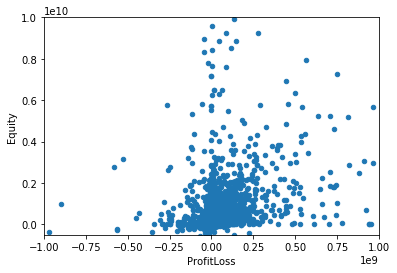

In [ ]:
#Create scatterplot of the two variables
file.loc[file["Year"] == 2015,["ProfitLoss","Equity"]].plot(xlim=[-1000000000,1000000000],ylim=[-500000000,10000000000],x="ProfitLoss",y="Equity",kind="scatter")


We would now like to check distribtional results in the data set. Lets look at the variable "ExecutiveAge" which beforehand we might believe has a certain distribition. First guess would be check if age is following a normal distribution. An easy way to do it - is by creating a histogram and try to fit the density of the normal distribution. Notive that the log-value of Executive age is used.    

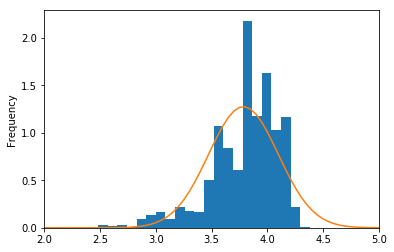

In [ ]:
#Import packages
import numpy as np
from scipy.stats import norm  
#Density function
#df = pd.DataFrame({'A': np.random.normal(size=1000)})
#df.A.plot(kind='hist', normed=True)

#Create vector with values from 0 to 10 with 0.05 in between. 
range = np.arange(0, 10, 0.05)

#Plot the histogram and density
file["LogExecutiveAge"].plot(kind="hist",xlim=[2,5],bins=30,density=True)
plt.plot(range, norm.pdf(range,file["LogExecutiveAge"].mean(),file["LogExecutiveAge"].std()))


It does not fit very well though... It is possible to do the same for "CompanyAge", but let us now check whether it follows a Poisson Distribution and let us code it directly. 

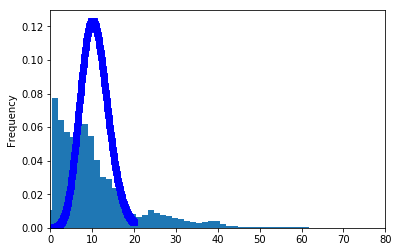

In [ ]:
#Import factorial function used in Poisson density
from scipy.special import factorial

#Make a vector with point between 0 and 20
t = np.arange(0, 20, 0.1)
#Define Poisson density
d = np.exp(-1*file["CompanyAge"].mean())*np.power(file["CompanyAge"].mean(), t)/factorial(t)

#Plot density and histogram
file["CompanyAge"].plot(kind="hist",xlim=[0,80],bins=200,density=True)
plt.plot(t, d, 'bs')

Which fits even worse than before. If we want to check it the distributional assumption in a less visual way we can do a QQ-plot. 

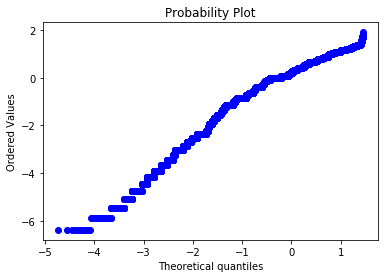

In [ ]:
#Import packages to do statistical analysis
import pylab
import scipy.stats as stats

#Standardize the variable
z = (file["LogExecutiveAge"]-np.mean(file["LogExecutiveAge"]))/np.std(file["LogExecutiveAge"])
#Create QQ-plot - for log-variable. 
stats.probplot(z,dist="norm",plot=pylab,fit=True)
plt.show()


Distributional assumptions seems better here to fit a normal distribution. Now we turn to something a bit different. First we import some packages to make sure we have everything we need. We then use the world bank API to take annual GDP from the US-economy. 

In [ ]:
#Import packages (maybe again)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas_datareader import wb
import datetime
import statsmodels.api as sm

#From the World Bank API take US gdp from 1989 to 2017
gdps_wb = wb.download(indicator = "NY.GDP.PCAP.KD",country=["US"],start=1989, end=2017) 

#API may be overloaded at times
#Try again in 5 minutes if this block fails

gdps_wb = gdps_wb.rename(columns = {"NY.GDP.PCAP.KD":"gdp"})
gdps_wb = gdps_wb.reset_index()
gdps_wb.head()
gdps_wb["Year"] = gdps_wb["year"].astype(int)

Now we would like to do some regressions, but we need one last dataset; namely the Star Wars dataset containing information about various Lego Star Wars sets. We first import packages to be used for the statistical analysis.  

We read the dataset the same way as before.

In [ ]:
#Define onlinelocation and user location. 
swfilelocation = "https://gist.githubusercontent.com/jncraton/68beb88e6027d9321373/raw/381dcf8c0d4534d420d2488b9c60b1204c9f4363/starwars.csv"
swfilename = "StarWarsPMisTheBest.csv"

#Prevent from downloading again
try:
    if os.stat(swfilename).st_size < 70000:
        raise    
except:
    testfile = urllib.request.URLopener()
    testfile.retrieve(swfilelocation,swfilename)
    
os.stat(swfilename).st_size #Make sure this is around 556835616

#Use panda to read the dataset
starwars = pd.read_csv(swfilename)

#Define new variables from the dataset
starwars["Pieces"] = starwars["Pieces"].astype(float)
starwars["USPrice"] = starwars["USPrice"].astype(float)
starwars["USPricePrPiece"] = starwars["USPrice"]/starwars["Pieces"]
starwars["Year"] = starwars["Year"].astype(int)
starwars["UKPrice"] = starwars["UKPrice"].astype(float)

#Remove missing values. 
starwars = starwars[pd.notnull(starwars["Pieces"])]
starwars = starwars[pd.notnull(starwars["USPrice"])]
starwars = starwars[pd.notnull(starwars["UKPrice"])]
starwars = starwars[pd.notnull(starwars["Year"])]
starwars = starwars[pd.notnull(starwars["Subtheme"])]



To give an even greater overview we create an interactive plot. It let the user see the mean value of used bricks in each Lego Star Wars set each year filtered by subtheme (eg. episodes)

In [ ]:
#Import widget package to create interactive plot
import ipywidgets as widgets

#Define function that is used to create interactive plot - use subtheme as variable and use year on the x-axis. 
def plot_e(dataframe, subtheme,column): 
    I = dataframe["Subtheme"] == subtheme
    dataframe.loc[I,:].groupby(["Year","Subtheme"]).mean()[column].unstack().plot(style="-o",legend = False)

#Use widget-package to create the plot
widgets.interact(plot_e, 
    dataframe = widgets.fixed(starwars),
    column = widgets.fixed("Pieces"),
    subtheme = widgets.Dropdown(description='Subtheme', options=starwars.Subtheme.unique(), value='Episode I')
); 

interactive(children=(Dropdown(description='Subtheme', index=4, options=('Ultimate Collector Series', 'Episode…

Now we define new variables using the mean every year and merge it with our corporate data set and US gdp.  

In [ ]:
#New mean variables
sw_usprice = starwars.groupby("Year").mean()["USPrice"]
sw_pieces = starwars.groupby("Year").mean()["Pieces"]
sw_usprice = sw_usprice.to_frame()
sw_pieces = sw_pieces.to_frame()

#Merge the three datasets together
sw_merge = pd.merge(sw_usprice,sw_pieces,how="inner",on=["Year"])
both_inner = pd.merge(gdps_wb,sw_merge,how="inner",left_on="Year",right_on="Year")

#both_inner.loc[:,["gdp","USPrice"]].plot(x="gdp",y="USPrice",kind="scatter")


We are then ready to perform a regression. Lets first do a simple regression between the price and bricks on the Lego-sets. 

In [ ]:
#Simple regression model
#Define regression model - dependent variable price and covariate pieces.
#Fit the model using OLS
reg1 = sm.OLS(starwars["USPrice"],starwars["Pieces"] ).fit()
#Predict using pieces
predictions = reg1.predict(starwars["Pieces"]) 
#Create regression summary
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                USPrice   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     9522.
Date:                Thu, 04 Apr 2019   Prob (F-statistic):          6.45e-225
Time:                        16:33:44   Log-Likelihood:                -1195.7
No. Observations:                 293   AIC:                             2393.
Df Residuals:                     292   BIC:                             2397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pieces         0.1028      0.001     97.582      0.000       0.101       0.105
==============================================================================
Omnibus:                       66.347   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1252.090
Skew:                          -0.216   Prob(JB):                    1.29e-272
Kurtosis:                      13.118   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems extra pieces increase price. 

We now want to do a multiple regression analysis linking danish corporate data, US-economy and the Star Wars dataset. We use the varibale "Executive Age" from the danish corporate data, US-gdp from the World Bank and US-price and pieces from the Star Wars data (though they might correlate as indicated by the first regression). First we merge the three datasets.    

In [ ]:
#take the mean of executive age at each year from 1980 and onwards.  
file = file[pd.notnull(file["Normal_start"])]
file["CompanyYear"] = file["Normal_start"].astype(str).str[:4].astype(int)

file = file.loc[file["CompanyYear"]>=1980,:]

#file.groupby("CompanyYear").mean()["ExecutiveAge"].plot()

In [ ]:
#Merge the three datasets. 
joinme = file.groupby("CompanyYear").mean()["ExecutiveAge"]
joinme = joinme.to_frame()
joinme.info()
both_inner = pd.merge(both_inner,joinme,how="inner",left_on = "Year",right_on = "CompanyYear")

In [ ]:
#Define log pieces as log of pieces
both_inner["LogPieces"] = np.log(both_inner["Pieces"])
both_inner.head(3)

In [ ]:
#Do the multiple regression
reg2 = sm.OLS(both_inner["gdp"], both_inner[["USPrice","LogPieces","ExecutiveAge"]]).fit()
predictions = reg2.predict(both_inner[["USPrice","LogPieces","ExecutiveAge"]]) 
reg2.summary()

Which seems to work "surprisingly" quite well. Let us take a look at the difference between the prediction of the model and the actual realizations of gdp to better see the fit.   

In [ ]:
#Calculate the predicted values using the parameters of the regression outcome. 
predict = list(zip(both_inner["Year"],both_inner["USPrice"]*(-225.2091)+both_inner["LogPieces"]*13240-468.1136*both_inner["ExecutiveAge"]))

predict = pd.DataFrame(predict,columns = ["Year","Prediction"])

predict = pd.merge(predict,both_inner,how="inner",left_on="Year",right_on="Year")

predict = predict.loc[:,["Year","Prediction","gdp"]]

predict

fig = plt.figure()

#Plot the difference 
plt.plot(predict["Year"],predict["Prediction"])
plt.plot(predict["Year"],predict["gdp"])
ax.legend()
plt.show()

#Plot percentage deviation
predict["Difference"] = (predict["Prediction"] - predict["gdp"])/predict["gdp"]

predict.loc[:,["Year","Difference"]].plot(x="Year",legend = False, title="Percentage deviation from actual values")


We might suspect that there is a correlation between executive age and gdp though the variable year. Lets take a look:

In [ ]:
#Plot executive age and gdp in scatter
both_inner.plot(x="ExecutiveAge",y="gdp",kind="scatter")

In [ ]:
#Plot gdp
gdps_wb.plot(x="Year")

In [ ]:
#Plot executive age
joinme = file.groupby("CompanyYear").mean()["ExecutiveAge"].plot()

So it seems that while gdp is increasing through the years, Executive age is falling. This concludes the data project.  

#### Conclusion
First we performed a data analysis on the danish corporate data and showed how to filter and the data in various ways. Furthermore, we presented different overviews over the data and the certain calculations such as mean log-transform. We performed analysis on distributional results and showed how to fit densities to distributions. We then showed how to use data from an API to fetch data from the World Bank. Lastly, we did some of the same procedures on the Star Wars dataset and showed how to interactively ascess the data. We merged all of the three datasets and performed st   
